In [1]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import time
from pathlib import Path
import json
import logging
from rich import print

from daq_data.daq_data_resources import format_stream_images_response
from daq_data.daq_data_client import DaqDataClient

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import deque
import textwrap

class PanoImagePreviewer:
    def __init__(
            self,
            stream_movie_data: bool,
            stream_pulse_height_data: bool,
            module_id_whitelist: list[int],
            logger: logging.Logger,
            text_width=25,
            font_size=7,
            row_height=2.8,
            window_size=100,
    ) -> None:
        self.stream_movie_data = stream_movie_data
        self.stream_pulse_height_data = stream_pulse_height_data
        self.module_id_whitelist = module_id_whitelist
        self.logger = logger

        self.seen_modules = set()
        self.axes_map = {}
        self.cbar_map = {}
        self.im_map = {}
        self.window_size = window_size
        self.max_pix_map = {'PULSE_HEIGHT': deque(maxlen=self.window_size), 'MOVIE': deque(maxlen=self.window_size)}
        self.min_pix_map = {'PULSE_HEIGHT': deque(maxlen=self.window_size), 'MOVIE': deque(maxlen=self.window_size)}

        self.fig = None
        self.text_width = text_width
        self.font_size = font_size
        self.cmap = 'plasma'
        self.row_height = row_height
        self.num_rescale = 0

    def setup_layout(self, modules):
        if self.fig is not None:
            plt.close(self.fig)
        modules = sorted(modules)
        n_modules = len(modules)
        self.fig, axs = plt.subplots(n_modules, 2, figsize=(self.row_height * 2.2, self.row_height * n_modules))
        if n_modules == 1:
            axs = np.array([axs])

        self.num_rescale = 0
        self.axes_map.clear()
        self.cbar_map.clear()
        self.im_map.clear()
        for row, module_id in enumerate(modules):
            self.axes_map[(module_id, 'PULSE_HEIGHT')] = axs[row, 0]
            self.axes_map[(module_id, 'MOVIE')] = axs[row, 1]

            im_ph = axs[row, 0].imshow(np.zeros((32, 32)), cmap=self.cmap)
            self.im_map[(module_id, 'PULSE_HEIGHT')] = im_ph
            im_mov = axs[row, 1].imshow(np.zeros((32, 32)), cmap=self.cmap)
            self.im_map[(module_id, 'MOVIE')] = im_mov

            divider_ph = make_axes_locatable(axs[row, 0])
            cax_ph = divider_ph.append_axes('right', size='5%', pad=0.05)
            cbar_ph = self.fig.colorbar(im_ph, cax=cax_ph)
            self.cbar_map[(module_id, 'PULSE_HEIGHT')] = cbar_ph

            divider_mov = make_axes_locatable(axs[row, 1])
            cax_mov = divider_mov.append_axes('right', size='5%', pad=0.05)
            cbar_mov = self.fig.colorbar(im_mov, cax=cax_mov)
            self.cbar_map[(module_id, 'MOVIE')] = cbar_mov
        self.fig.tight_layout()

    def update(self, parsed_pano_image):
        module_id = parsed_pano_image['module_id']
        pano_type = parsed_pano_image['type']
        header = parsed_pano_image['header']
        img = parsed_pano_image['image_array']
        frame_number = parsed_pano_image['frame_number']
        file = parsed_pano_image['file']

        # If this module is new, update layout and clear output before redrawing
        if module_id not in self.seen_modules:
            self.seen_modules.add(module_id)
            self.setup_layout(self.seen_modules)

        self.max_pix_map[pano_type].append(np.max(img))
        self.min_pix_map[pano_type].append(np.min(img))
        vmax = np.quantile(self.max_pix_map[pano_type], 0.95)
        vmin = np.quantile(self.min_pix_map[pano_type], 0.05)
        im = self.im_map[(module_id, pano_type)]
        im.set_data(img)
        im.set_clim(vmin, vmax)

        cbar = self.cbar_map.get((module_id, pano_type))
        cbar.ax.tick_params(labelsize=8)
        cbar.locator = MaxNLocator(nbins=6)
        cbar.update_ticks()
        cbar.ax.set_ylabel('ADC', rotation=270, labelpad=10, fontsize=8)
        cbar.ax.yaxis.set_label_position("right")

        ax = self.axes_map.get((module_id, pano_type))
        if ax is None:
            return

        ax_title = (f"{pano_type}"
                    + ("\n" if 'quabo_num' not in header else f": Q{int(header['quabo_num'])}\n")
                    + f"unix_t = {header['pandas_unix_timestamp'].time()}\n"
                    + f"frame_no = {frame_number}\n")
        ax_title += textwrap.fill(f"file = {file}", width=self.text_width)

        ax.set_title(ax_title, fontsize=self.font_size)
        ax.tick_params(axis='both', which='major', labelsize=8, length=4, width=1)

        start = pff.parse_name(file)['start'] if 'pff' in globals() else ''
        if len(self.module_id_whitelist) > 0:
            plt_title = f"Obs data from {start}, module_ids={set(self.module_id_whitelist)} [filtered]"
        else:
            plt_title = f"Obs data from {start}, module_ids={self.seen_modules} [all]"
        if self.num_rescale < len(self.seen_modules) * 3:
            self.fig.tight_layout()
            self.num_rescale += 1
        self.fig.suptitle(plt_title)

        clear_output(wait=True)
        display(self.fig)


In [3]:
# load config and paths
cfg_dir = Path('daq_data/config')
daq_config_file = 'daq_config_grpc_simulate.json'
hp_io_config_simulate_file = 'hp_io_config_simulate.json'
with open(cfg_dir / hp_io_config_simulate_file, 'r') as f:
    hp_io_cfg = json.load(f)

with open(cfg_dir / daq_config_file, 'r') as f:
    daq_config = json.load(f)

In [7]:
# initialize the server
with DaqDataClient(daq_config, log_level=logging.WARNING) as ddc:
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    for host in valid_daq_hosts:
        print(f"checking connection to {host=}")
        ddc.reflect_services(host)
        print(f"initializing {host=}")
        # initialize the server with simulation data
        init_success = ddc.init_sim(host)
        print(f"{init_success=}")
        if not init_success:
            raise RuntimeError(f'failed to initialize {host=}')

checking connection to host='localhost'

15:33:33 INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=677050;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=813860;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: daq_data.proto                                                            

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=4661;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=610037;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: google/protobuf/struct.proto                                              

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=724717;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=156375;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file:                                                                           
                  google/protobuf/timestamp.proto                                                                  

initializing host='localhost'

init_success=True

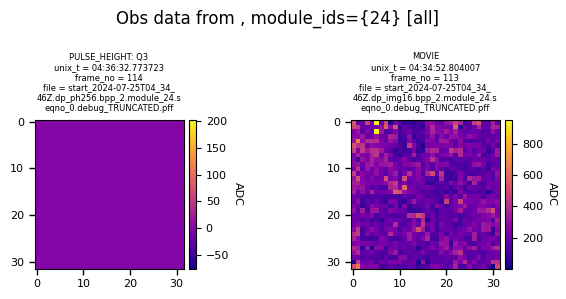

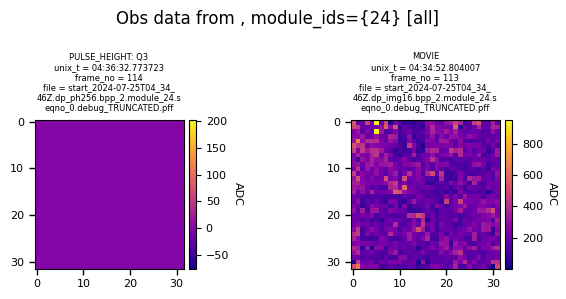

In [9]:
# stream images: config 
stream_movie_data = True
stream_pulse_height_data = True
update_interval_seconds=0.5

# stream images: calls
with DaqDataClient(daq_config) as ddc:
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    # create visualizer
    previewer = PanoImagePreviewer(
        stream_movie_data, stream_pulse_height_data, [], ddc.logger, row_height=3, font_size=6, text_width=30, window_size=1000
    )
    # Call the StreamImages RPC on all active DAQ nodes for previewing pulse-height and movie-mode data
    streams = []
    for host in valid_daq_hosts:
        stream = ddc.stream_images(
            host,
            stream_movie_data,
            stream_pulse_height_data,
            update_interval_seconds,
            wait_for_ready=True,
            parse_pano_images=True,
        )
        streams.append(stream)

    # Update plots with data from the return streams
    while True:
        for stream in streams:
            pano_image = next(stream)
            previewer.update(pano_image)